## Seminary 1

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import json

### Task 1: Representation

In [4]:
def load_data(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    return data

def parse_json(data):
    N = data["num_papers"]
    K = data["num_reviewers"]
    R = data["reviewer_capacity"]
    min_reviews_per_paper = data["min_reviews_per_paper"]
    max_reviews_per_paper = data["max_reviews_per_paper"]
    
    preference_matrix = np.array(data["preferences"])             ### make all the matrices as ... matrices ofc
    friendship_matrix = np.array(data["friendships"])
    authorship_matrix = np.array(data["authorship"])
    
    return (N, K, R, min_reviews_per_paper, max_reviews_per_paper,
            preference_matrix, friendship_matrix, authorship_matrix)

In [45]:
def fitness_function(assignment, preference_matrix, friendship_matrix, authorship_matrix,
                     capacity, min_reviews_per_paper, max_reviews_per_paper):
    
    fitness = np.sum(assignment * preference_matrix)
    penalty = 0

    # fitness += np.sum(assignment * preference_matrix)
    for j in range(assignment.shape[0]):
        reviews_assigned = assignment[j, :].sum()
        if reviews_assigned > capacity:
            penalty += (reviews_assigned - capacity) * 2

    for i in range(assignment.shape[1]):
        reviews_needed = assignment[:, i].sum()
        if reviews_needed < min_reviews_per_paper:
            penalty += (min_reviews_per_paper - reviews_needed) * 2
        elif reviews_needed > max_reviews_per_paper:
            penalty += (reviews_needed - max_reviews_per_paper) * 2

    for i in range(assignment.shape[0]):
        for j in range(assignment.shape[1]):
            if assignment[i, j] == 1:
                for k in range(authorship_matrix[:, j].shape[0]):
                    if authorship_matrix[k, j] == 1 and friendship_matrix[i, k] == 1:
                        penalty += 5
                # for k in range(j + 1, assignment.shape[1]):
                #     if assignment[i, k] == 1 and friendship_matrix[j, k] == 1:
                #         penalty += 5

    # penalty += np.sum(assignment * friendship_matrix) * 5
    penalty += np.sum(assignment * authorship_matrix) * 6
    return fitness - penalty

In [47]:
def generate_random_assignment(num_papers, num_reviewers, reviewer_capacity,
                               min_reviews_per_paper, max_reviews_per_paper):
    
    assignment = np.zeros((num_reviewers, num_papers), dtype=int)
    
    for i in range(num_papers):
        reviewers = np.random.choice(range(num_reviewers), 
                                     size=np.random.randint(min_reviews_per_paper, max_reviews_per_paper + 1), 
                                     replace=False)
        assignment[reviewers, i] = 1
    
    for j in range(num_reviewers):
        while assignment[j, :].sum() > reviewer_capacity:
            assigned_papers = np.where(assignment[j, :] == 1)[0]
            paper_to_remove = np.random.choice(assigned_papers)
            assignment[j, paper_to_remove] = 0

    return assignment

In [50]:
import random

def initialize_population(pop_size, N, K, R, min_reviews, max_reviews):                                #### generate the first population
    return [generate_random_assignment(N, K, R, min_reviews, max_reviews) for _ in range(pop_size)]

# def select_parents(population, fitness_scores):                                   #### find the parents
#     fitness_sum = sum(fitness_scores)
#     probabilities = [score / fitness_sum for score in fitness_scores]
#     parents = random.choices(population, weights=probabilities, k=2)
#     return parents
 
# def crossover(parent1, parent2):                                                  #### crossover by swapping
#     num_rev, num_pap = parent1.shape
#     crossover_point = random.randint(0, num_rev - 1)
#     child1 = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
#     child2 = np.vstack((parent2[:crossover_point], parent1[crossover_point:]))
#     return child1, child2

def mutate(assignment, R, min_reviews, max_reviews):                             #### mutate by flipping a random entry 0->1 or 1->0
    num_rev, num_pap = assignment.shape
    num_mutates = random.randint(1, 5)
    for n in range(num_mutates):
        i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
        assignment[i, j] = 1 - assignment[i, j]  
    
        if assignment[i, :].sum() > R:
            assignment[i, j] = 0
        if assignment[i, :].sum() < min_reviews:
            assignment[i, j] = 1
        elif assignment[i, :].sum() > max_reviews:
            assignment[i, j] = 0
    return assignment

def mutate_swap(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    k, l = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    
    assignment[i, j], assignment[k, l] = assignment[k, l], assignment[i, j]
    
    if assignment[i, :].sum() > R:
        assignment[i, j] = 0
    if assignment[i, :].sum() < min_reviews:
        assignment[i, j] = 1
    elif assignment[i, :].sum() > max_reviews:
        assignment[i, j] = 0
    
    if assignment[k, :].sum() > R:
        assignment[k, l] = 0
    if assignment[k, :].sum() < min_reviews:
        assignment[k, l] = 1
    elif assignment[k, :].sum() > max_reviews:
        assignment[k, l] = 0
    
    return assignment

def mutate_scramble(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    np.random.shuffle(assignment[i, start:end+1])
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

def mutate_inversion(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    assignment[i, start:end+1] = assignment[i, start:end+1][::-1]
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

def crossover_one_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    crossover_point = random.randint(0, num_rev - 1)
    child1 = np.vstack((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.vstack((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def crossover_two_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    point1, point2 = sorted(random.sample(range(num_rev), 2))
    child1 = np.vstack((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    child2 = np.vstack((parent2[:point1], parent1[point1:point2], parent2[point2:]))
    return child1, child2

def crossover_uniform(parent1, parent2):
    num_rev, num_pap = parent1.shape
    child1, child2 = np.zeros_like(parent1), np.zeros_like(parent2)
    for i in range(num_rev):
        if random.random() > 0.5:
            child1[i, :], child2[i, :] = parent1[i, :], parent2[i, :]
        else:
            child1[i, :], child2[i, :] = parent2[i, :], parent1[i, :]
    return child1, child2

def proportional_selection(population, fitness_scores):
    fitness_sum = sum(fitness_scores)
    probabilities = [score / fitness_sum for score in fitness_scores]
    parents = random.choices(population, weights=probabilities, k=2)
    return parents

def rank_based_selection(population, fitness_scores):
    ranks = np.argsort(np.argsort(fitness_scores)) + 1
    total_rank = np.sum(ranks)
    
    probabilities = ranks / total_rank
    parents = random.choices(population, weights=probabilities, k=2)
    
    return parents

def tournament_selection(population, fitness_scores, tournament_size=10):
    selected = random.sample(list(zip(population, fitness_scores)), tournament_size)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0], selected[1][0]

def select_parents(population, fitness_scores, selection_method='proportional'):
    if selection_method == 'proportional':
        return proportional_selection(population, fitness_scores)
    elif selection_method == 'rank-based':
        return rank_based_selection(population, fitness_scores)
    elif selection_method == 'tournament':
        return tournament_selection(population, fitness_scores)
    else:
        raise ValueError("Invalid selection method")
    
def select_crossover(crossover_method, parent1, parent2):
    if crossover_method == 'one-point':
        return crossover_one_point(parent1, parent2)
    elif crossover_method == 'two-point':
        return crossover_two_point(parent1, parent2)
    elif crossover_method == 'uniform':
        return crossover_uniform(parent1, parent2)
    else:
        raise ValueError("Invalid crossover method")
    
def select_mutation(mutation_method, child, R, min_reviews, max_reviews):
    if mutation_method == 'random':
        return mutate(child, R, min_reviews, max_reviews)
    elif mutation_method == 'swap':
        return mutate_swap(child, R, min_reviews, max_reviews)
    elif mutation_method == 'scramble':
        return mutate_scramble(child, R, min_reviews, max_reviews)
    elif mutation_method == 'inversion':
        return mutate_inversion(child, R, min_reviews, max_reviews)
    else:
        raise ValueError("Invalid mutation method")

def genetic_algorithm(num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix, generations=100, pop_size=20, 
                      parents_mating=2, selection_method='proportional', crossover_method='one-point', mutation_method='scramble'):
    population = initialize_population(pop_size, num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews)
    best_fitness_scores = []
    
    for generation in range(generations):
        fitness_scores = [fitness_function(ind, preference_matrix, friendship_matrix, authorship_matrix, reviewer_capacity, min_reviews, max_reviews) for ind in population]
        new_population = []
        
        while len(new_population) < pop_size:
            parent1, parent2 = select_parents(population, fitness_scores, selection_method)
            
            child1, child2 = select_crossover(crossover_method, parent1, parent2)
            
            child1 = select_mutation(mutation_method, child1, reviewer_capacity, min_reviews, max_reviews)
            child2 = select_mutation(mutation_method, child2, reviewer_capacity, min_reviews, max_reviews)
            
            new_population.extend([child1, child2])
        
        population = new_population[:pop_size]
        best_fitness = max(fitness_scores)
        best_fitness_scores.append(best_fitness)
        # print(f"Generation {generation + 1}: Best Fitness = {best_fitness}")

    best_index = np.argmax(fitness_scores)
    return population[best_index], best_fitness_scores


The best is:  [[0 0 0 1 1 0 0 0 1 0 1 0 0 0 1]
 [1 0 0 1 0 1 0 0 0 0 0 1 0 1 0]
 [0 0 1 1 1 0 0 0 1 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 1 0 1 0 0 0 1]
 [0 1 0 0 0 0 1 1 0 0 0 0 1 1 0]
 [0 0 0 1 1 0 0 1 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 1 0]
 [1 0 0 0 1 0 1 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 1 1 0 1 0 1]
 [0 0 0 0 0 1 1 1 0 0 0 1 0 1 0]]


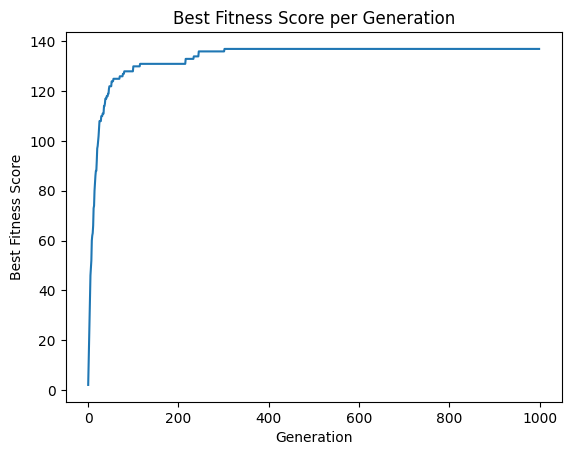

In [51]:
json_file_path = 'datasets/hard_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

best_assignment, fitness_scores = genetic_algorithm(
    num_papers=N, 
    num_reviewers=K, 
    reviewer_capacity=R, 
    min_reviews=min_reviews_per_paper, 
    max_reviews=max_reviews_per_paper, 
    preference_matrix=preference_matrix,
    friendship_matrix=friendship_matrix,
    authorship_matrix=authorship_matrix,
    generations=1000,
    pop_size=50,
    parents_mating = 2,
    selection_method='tournament',
    crossover_method='one-point',
    mutation_method='swap'
)

print("The best is: ", best_assignment)

#### Plot the fitness scores
plt.plot(fitness_scores)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Score')
plt.title('Best Fitness Score per Generation')
plt.show()


##### Test the first functions
# print(parse_json(data))
# assignment = generate_random_assignment(N, K, R, min_reviews_per_paper, max_reviews_per_paper)
# fitness_score = fitness_function(assignment, preference_matrix, friendship_matrix, 
#                                 authorship_matrix, R, min_reviews_per_paper, max_reviews_per_paper)       
# print(assignment)
# print("Score: ", fitness_score)

### Task 4: Evaluation

In [53]:
import time
dataset_paths = ['datasets/easy_dataset_1.json','datasets/easy_dataset_2.json',
                 'datasets/medium_dataset_1.json','datasets/medium_dataset_2.json',
                 'datasets/hard_dataset_1.json','datasets/hard_dataset_2.json','datasets/hard_dataset_3.json', 'datasets/hard_dataset_4.json']

def load_and_parse_data(file_path):
    data = load_data(file_path)
    return parse_json(data)

results = []

configurations = [
    ('proportional', 'one-point', 'swap'),
    ('rank-based', 'two-point', 'scramble'),
    ('tournament', 'uniform', 'inversion')
]

for dataset_path in dataset_paths:
    N, K, R, min_reviews, max_reviews, preference_matrix, friendship_matrix, authorship_matrix = load_and_parse_data(dataset_path)
    
    for selection_method, crossover_method, mutation_method in configurations:
        print(f"Evaluating configuration: {selection_method}, {crossover_method}, {mutation_method}")
        
        start_time = time.time()
        best_assignment, fitness_scores = genetic_algorithm(
            num_papers=N, 
            num_reviewers=K, 
            reviewer_capacity=R, 
            min_reviews=min_reviews, 
            max_reviews=max_reviews, 
            preference_matrix=preference_matrix,
            friendship_matrix=friendship_matrix,
            authorship_matrix=authorship_matrix,
            generations=100,
            pop_size=20,
            parents_mating=2,
            selection_method=selection_method,
            crossover_method=crossover_method,
            mutation_method=mutation_method
        )
        runtime = time.time() - start_time
        best_fitness = max(fitness_scores)
        
        # Store results for analysis
        results.append({
            'dataset': dataset_path,
            'selection_method': selection_method,
            'crossover_method': crossover_method,
            'mutation_method': mutation_method,
            'best_fitness': best_fitness,
            'runtime': runtime
        })
results_df = pd.DataFrame(results)

print(results_df)

# 5. Conclusion and Recommendations
# Discuss which configurations performed best and why, as well as potential trade-offs.

# # Save the notebook or export results to a CSV for further analysis
# results_df.to_csv('evaluation_results.csv', index=False)


Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tournament, uniform, inversion
Evaluating configuration: proportional, one-point, swap
Evaluating configuration: rank-based, two-point, scramble
Evaluating configuration: tourn

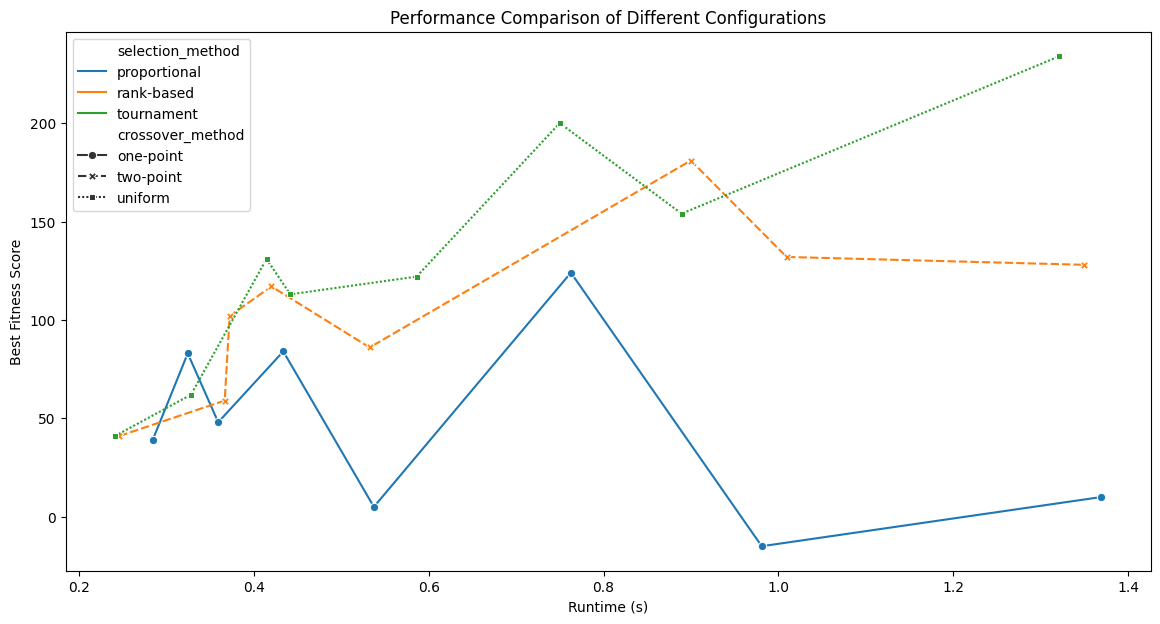

In [54]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='runtime', y='best_fitness', hue='selection_method', style='crossover_method', markers=True)
plt.title('Performance Comparison of Different Configurations')
plt.xlabel('Runtime (s)')
plt.ylabel('Best Fitness Score')
plt.show()

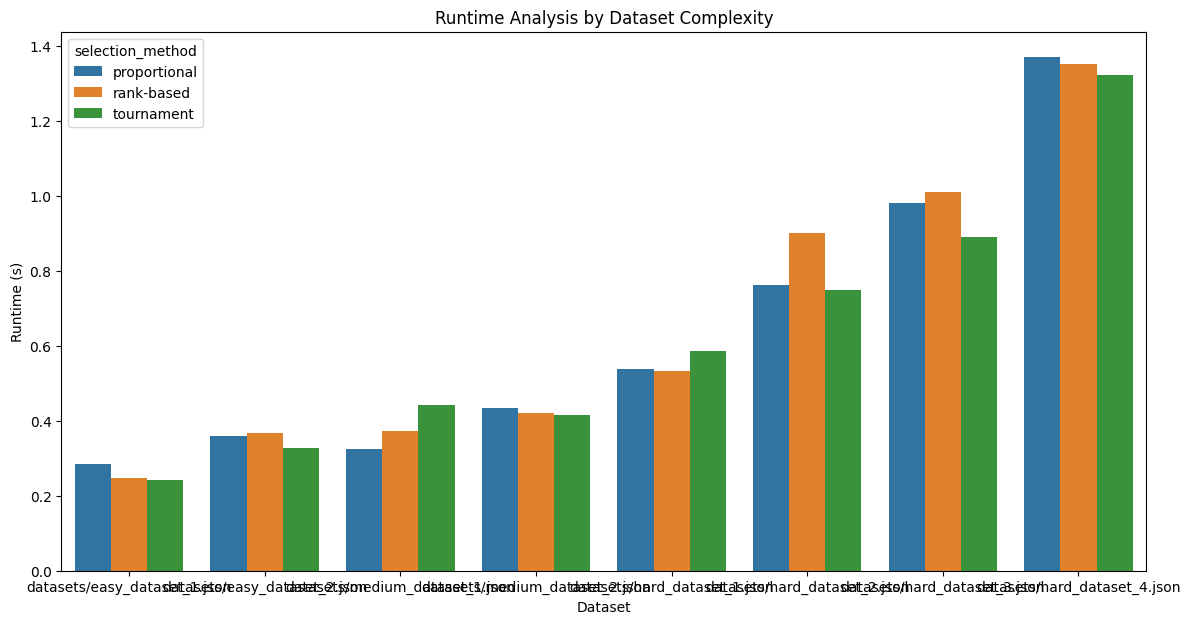

In [55]:
plt.figure(figsize=(14, 7))
sns.barplot(x='dataset', y='runtime', hue='selection_method', data=results_df)
plt.title('Runtime Analysis by Dataset Complexity')
plt.xlabel('Dataset')
plt.ylabel('Runtime (s)')
plt.show()


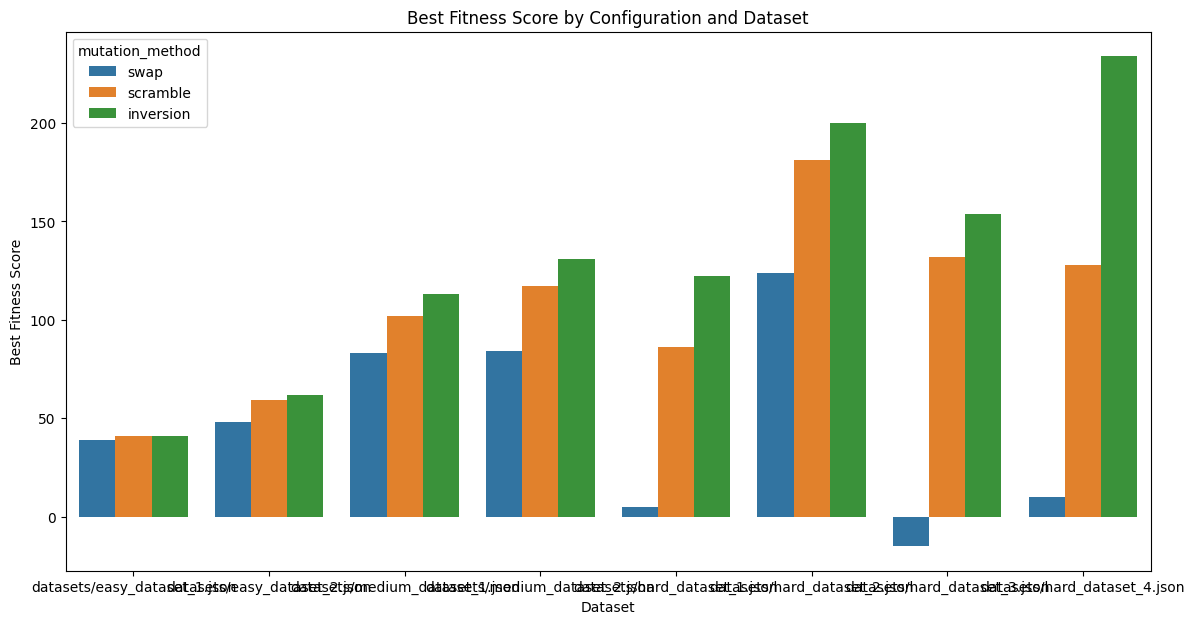

In [56]:

plt.figure(figsize=(14, 7))
sns.barplot(x='dataset', y='best_fitness', hue='mutation_method', data=results_df)
plt.title('Best Fitness Score by Configuration and Dataset')
plt.xlabel('Dataset')
plt.ylabel('Best Fitness Score')
plt.show()


### Task 2: Crossover & Mutation

In [9]:
import pygad

In [9]:
def pygad_fitness(pygad_instance, solution, solution_idx):
    assignment = solution.reshape((K, N))
    return fitness_function(assignment, preference_matrix, friendship_matrix, authorship_matrix,
                            R, min_reviews_per_paper, max_reviews_per_paper)

In [10]:
json_file_path = 'datasets/easy_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

In [11]:
def select_parents(population, fitness_scores):                                   #### find the parents
    fitness_sum = sum(fitness_scores)
    probabilities = [score / fitness_sum for score in fitness_scores]
    parents = random.choices(population, weights=probabilities, k=2)
    return parents
 
def crossover(pygad_instance, parent1, parent2):     
    print(parent1)                                             #### crossover by swapping
    crossover_point = random.randint(0, K - 1)
    child1 = np.vstack((parent1[:crossover_point, :], parent2[crossover_point:, :]))
    child2 = np.vstack((parent2[:crossover_point, :], parent1[crossover_point:, :]))
    return child1, child2

def mutate(assignment, R, min_reviews, max_reviews):                             #### mutate by flipping a random entry 0->1 or 1->0
    num_rev, num_pap = assignment.shape
    i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    assignment[i, j] = 1 - assignment[i, j]  
    
    if assignment[i, :].sum() > R:
        assignment[i, j] = 0
    if assignment[i, :].sum() < min_reviews:
        assignment[i, j] = 1
    elif assignment[i, :].sum() > max_reviews:
        assignment[i, j] = 0
    return assignment

In [12]:
ga_instance = pygad.GA(
                        fitness_func=pygad_fitness,
                        num_generations=100,
                        num_parents_mating=2,
                        sol_per_pop=20,
                        num_genes= N * K,              
                        gene_space=[0, 1],            
                        mutation_type="swap",
                        crossover_type=crossover,
                        allow_duplicate_genes=True,  
                        stop_criteria="saturate_15"   
                    )
ga_instance.run()

c:\Users\user\anaconda3\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
tuple indices must be integers or slices, not tuple
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\Lib\site-packages\pygad\pygad.py", line 1962, in run
    self.run_crossover()
  File "c:\Users\user\anaconda3\Lib\site-packages\pygad\pygad.py", line 2221, in run_crossover
    self.last_generation_offspring_crossover = self.crossover(self.last_generation_parents,
                                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

(19, 25)


TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
best_sol, best_solution_fitness, _ = ga_instance.best_solution()
best_sol = best_sol.reshape((K,N))
best_sol

array([[1, 1, 0, 1, 1],
       [1, 0, 1, 1, 0],
       [0, 1, 1, 0, 1],
       [0, 1, 1, 1, 0],
       [1, 0, 0, 0, 1]])

In [39]:
import time

def fitness_function(ga_instance, solution, solution_idx):
    assignment = solution.reshape(ga_instance.preference_matrix.shape)

    fitness = np.sum(assignment * ga_instance.preference_matrix)
    penalty = 0

    for j in range(assignment.shape[0]):
        reviews_assigned = assignment[j, :].sum()
        if reviews_assigned > ga_instance.capacity:
            penalty += (reviews_assigned - ga_instance.capacity) * 2

    for i in range(assignment.shape[1]):
        reviews_needed = assignment[:, i].sum()
        if reviews_needed < ga_instance.min_reviews_per_paper:
            penalty += (ga_instance.min_reviews_per_paper - reviews_needed) * 2
        elif reviews_needed > ga_instance.max_reviews_per_paper:
            penalty += (reviews_needed - ga_instance.max_reviews_per_paper) * 2

    for i in range(assignment.shape[0]):
        for j in range(assignment.shape[1]):
            if assignment[i, j] == 1:
                for k in range(ga_instance.authorship_matrix[:, j].shape[0]):
                    if ga_instance.authorship_matrix[k, j] == 1 and ga_instance.friendship_matrix[i, k] == 1:
                        penalty += 5

    penalty += np.sum(assignment * ga_instance.authorship_matrix) * 6

    return fitness - penalty


def initialize_population(pop_size, N, K, R, min_reviews, max_reviews):                                #### generate the first population
    population = [
        generate_random_assignment(N, K, R, min_reviews, max_reviews).flatten()
        for _ in range(pop_size)
    ]
    return np.array(population)


def mutate(assignment, R, min_reviews, max_reviews):                             #### mutate by flipping a random entry 0->1 or 1->0
    num_rev, num_pap = assignment.shape
    num_mutates = random.randint(1, 5)
    for n in range(num_mutates):
        i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
        assignment[i, j] = 1 - assignment[i, j]  
    
        if assignment[i, :].sum() > R:
            assignment[i, j] = 0
        if assignment[i, :].sum() < min_reviews:
            assignment[i, j] = 1
        elif assignment[i, :].sum() > max_reviews:
            assignment[i, j] = 0
    return assignment

def mutate_swap(offspring, ga_instance):
    num_rev, num_pap = offspring.shape

    # Perform a single mutation (swap)
    i, j = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)
    k, l = random.randint(0, num_rev - 1), random.randint(0, num_pap - 1)

    # Swap two values
    offspring[i, j], offspring[k, l] = offspring[k, l], offspring[i, j]

    # Ensure constraints
    for reviewer in range(num_rev):
        total_reviews = offspring[reviewer, :].sum()
        if total_reviews > ga_instance.capacity:
            for paper in range(num_pap):
                if offspring[reviewer, paper] == 1:
                    offspring[reviewer, paper] = 0
                    total_reviews -= 1
                    if total_reviews <= ga_instance.capacity:
                        break

    return offspring


def mutate_scramble(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    np.random.shuffle(assignment[i, start:end+1])
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

def mutate_inversion(assignment, R, min_reviews, max_reviews):
    num_rev, num_pap = assignment.shape
    i = random.randint(0, num_rev - 1)
    start, end = sorted(random.sample(range(num_pap), 2))
    
    assignment[i, start:end+1] = assignment[i, start:end+1][::-1]
    
    if assignment[i, :].sum() > R:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= R:
                    break
    if assignment[i, :].sum() < min_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 0:
                assignment[i, j] = 1
                if assignment[i, :].sum() >= min_reviews:
                    break
    elif assignment[i, :].sum() > max_reviews:
        for j in range(start, end+1):
            if assignment[i, j] == 1:
                assignment[i, j] = 0
                if assignment[i, :].sum() <= max_reviews:
                    break
    
    return assignment

def crossover_one_point(parents, offspring_size, ga_instance):
    offspring = []
    crossover_point = np.random.randint(1, parents.shape[1])  # Random crossover point

    for k in range(offspring_size[0]):  # Generate each offspring
        parent1_idx = k % parents.shape[0]
        parent2_idx = (k + 1) % parents.shape[0]

        # Split parents at the crossover point
        parent1 = parents[parent1_idx]
        parent2 = parents[parent2_idx]

        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)

    return np.array(offspring)


def crossover_two_point(parent1, parent2):
    num_rev, num_pap = parent1.shape
    point1, point2 = sorted(random.sample(range(num_rev), 2))
    child1 = np.vstack((parent1[:point1], parent2[point1:point2], parent1[point2:]))
    child2 = np.vstack((parent2[:point1], parent1[point1:point2], parent2[point2:]))
    return child1, child2

def crossover_uniform(parent1, parent2):
    num_rev, num_pap = parent1.shape
    child1, child2 = np.zeros_like(parent1), np.zeros_like(parent2)
    for i in range(num_rev):
        if random.random() > 0.5:
            child1[i, :], child2[i, :] = parent1[i, :], parent2[i, :]
        else:
            child1[i, :], child2[i, :] = parent2[i, :], parent1[i, :]
    return child1, child2

def proportional_selection(population, fitness_scores):
    fitness_sum = sum(fitness_scores)
    probabilities = [score / fitness_sum for score in fitness_scores]
    parents = random.choices(population, weights=probabilities, k=2)
    return parents

def rank_based_selection(population, fitness_scores):
    ranks = np.argsort(np.argsort(fitness_scores)) + 1
    total_rank = np.sum(ranks)
    
    probabilities = ranks / total_rank
    parents = random.choices(population, weights=probabilities, k=2)
    
    return parents

def tournament_selection(fitness_values, num_parents, ga_instance, tournament_size=3):
    selected_parents = []

    population = ga_instance.population  # Access the population from the GA instance

    for _ in range(num_parents):  # Loop to select pairs of parents
        # Randomly select `tournament_size` candidates
        tournament = random.sample(list(zip(population, fitness_values)), tournament_size)
        # Sort the candidates by fitness in descending order
        sorted_tournament = sorted(tournament, key=lambda x: x[1], reverse=True)
        # Select the top 2 from the sorted list
        top_two = sorted_tournament[:2]
        # Append their solutions (genes) to the selected parents list
        selected_parents.append(top_two[0][0])  # Top 1
        selected_parents.append(top_two[1][0])  # Top 2

    # Convert to a 2D NumPy array
    return np.array(selected_parents).reshape(-1, ga_instance.num_genes)

# def select_parents(population, fitness_scores, selection_method='proportional'):
#     if selection_method == 'proportional':
#         return proportional_selection(population, fitness_scores)
#     elif selection_method == 'rank-based':
#         return rank_based_selection(population, fitness_scores)
#     elif selection_method == 'tournament':
#         return tournament_selection(population, fitness_scores)
#     else:
#         raise ValueError("Invalid selection method")
    
# def select_crossover(crossover_method, parent1, parent2):
#     if crossover_method == 'one-point':
#         return crossover_one_point(parent1, parent2)
#     elif crossover_method == 'two-point':
#         return crossover_two_point(parent1, parent2)
#     elif crossover_method == 'uniform':
#         return crossover_uniform(parent1, parent2)
#     else:
#         raise ValueError("Invalid crossover method")
    
# def select_mutation(mutation_method, child, R, min_reviews, max_reviews):
#     if mutation_method == 'random':
#         return mutate(child, R, min_reviews, max_reviews)
#     elif mutation_method == 'swap':
#         return mutate_swap(child, R, min_reviews, max_reviews)
#     elif mutation_method == 'scramble':
#         return mutate_scramble(child, R, min_reviews, max_reviews)
#     elif mutation_method == 'inversion':
#         return mutate_inversion(child, R, min_reviews, max_reviews)
#     else:
#         raise ValueError("Invalid mutation method")

# def custom_crossover_function(parents, offspring_size, crossover_method):
#     offspring = np.empty(offspring_size, dtype=parents.dtype)

#     # One-point crossover implementation
#     crossover_point = np.random.randint(1, parents.shape[1])  # Random crossover point

#     for k in range(offspring_size[0]):
#         parent1_idx = k % parents.shape[0]
#         parent2_idx = (k + 1) % parents.shape[0]

#         # Generate offspring by combining genes
#         offspring[k, :crossover_point] = parents[parent1_idx, :crossover_point]
#         offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]

#     return offspring

# # Custom Mutation Function
# def custom_mutation_function(offspring, ga_instance):
#     mutation_probability = 0.1  # You can set this value directly or use a parameter from `ga_instance`
#     mutation_method = 'scramble'  # Specify your mutation method
    
#     R = ga_instance.R  # Example of accessing a custom attribute in the GA instance
#     min_reviews = ga_instance.min_reviews
#     max_reviews = ga_instance.max_reviews

#     for idx in range(offspring.shape[0]):
#         # if np.random.rand() < mutation_probability:
#         offspring[idx] = select_mutation(mutation_method, offspring[idx], R, min_reviews, max_reviews)
    
#     return offspring


# # Custom Parent Selection Function
# def custom_parent_selection_function(fitness, num_parents, population, selection_method):
#     parents = []
#     for _ in range(num_parents):
#         parent1, _ = select_parents(population, fitness, selection_method)
#         parents.append(parent1)
#     return np.array(parents)

def delay_on_generation(ga_instance):
    time.sleep(1)  # Add a delay of 1 second

# Genetic Algorithm using PyGAD
def genetic_algorithm_pygad(num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews, preference_matrix, 
                             friendship_matrix, authorship_matrix, generations=100, pop_size=20, parents_mating=2, 
                             selection_method='proportional', crossover_method='one-point', mutation_method='scramble', 
                             mutation_probability=0.1):
    
    # population = initialize_population(pop_size, num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews)
    # PyGAD GA Instance
    ga_instance = pygad.GA(
        num_generations=generations,
        num_parents_mating=2,  
        initial_population=initialize_population(pop_size, num_papers, num_reviewers, reviewer_capacity, min_reviews, max_reviews),
        fitness_func=lambda ga_instance, sol, idx: fitness_function(ga_instance, sol, idx),
        # crossover_type="custom",
        crossover_type=crossover_one_point,
        # mutation_type="custom",
        mutation_type=mutate_swap,
        # parent_selection_type="custom",
        parent_selection_type=lambda fitness, num_parents, ga_instance: tournament_selection(fitness, num_parents, ga_instance, tournament_size=3)
        # on_generation=delay_on_generation
    )

    ga_instance.preference_matrix = preference_matrix
    ga_instance.friendship_matrix = friendship_matrix
    ga_instance.authorship_matrix = authorship_matrix
    ga_instance.capacity = reviewer_capacity
    ga_instance.min_reviews_per_paper = min_reviews
    ga_instance.max_reviews_per_paper = max_reviews

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    return solution, solution_fitness, ga_instance

In [40]:
json_file_path = 'datasets/hard_dataset_1.json'     ### change the dataset if needed

data = load_data(json_file_path)
(N, K, R, min_reviews_per_paper, max_reviews_per_paper,
    preference_matrix, friendship_matrix, authorship_matrix) = parse_json(data)

solution, fitness, ga_instance = genetic_algorithm_pygad(
    N, K, R, min_reviews_per_paper, max_reviews_per_paper, 
    preference_matrix, friendship_matrix, authorship_matrix,
    generations=1000, pop_size=20, crossover_method='one-point', mutation_method='scramble'
)

print(solution)
print(fitness)
ga_instance.plot_fitness()

too many values to unpack (expected 2)
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\intelsys\lib\site-packages\pygad\pygad.py", line 1956, in run
    self.run_select_parents()
  File "c:\Users\user\anaconda3\envs\intelsys\lib\site-packages\pygad\pygad.py", line 2119, in run_select_parents
    self.last_generation_parents, self.last_generation_parents_indices = self.select_parents(self.last_generation_fitness,
ValueError: too many values to unpack (expected 2)


ValueError: too many values to unpack (expected 2)